## Import modules/scripts and optimize portfolio weights:

In [22]:
from datetime import date, datetime
from cov_matrix import MPTCovMat, WeightOptimizer
from JSONReader import read_json
import pandas as pd
import yfinance as yf
import torch

ticker_list = read_json('omxs30.json')
tickers = yf.Tickers(ticker_list)
start = date(2015,1,1)
end = date(2022,10,6)

#get data
data = MPTCovMat(tickers=tickers,start=start,end=end)
returns = data.log_return_df
col_indices = data.col_indices
asset_names = [col_indices[i] for i in sorted(col_indices.keys())]

num_iter = 10000
allocator = WeightOptimizer(lr=1e-3,cov_matrix=torch.tensor(data.cov_matrix.values),returns=torch.tensor(returns.values),risk_free=0.01,num_iter=num_iter)
sharpes, pf_returns, pf_stds = allocator.optimize_weights()
weights = pd.DataFrame(allocator.alloc_weights.numpy(force=True), index=asset_names, columns=['Weights'])
weights.index.name = 'Ticker'
weights['Weights %'] = weights['Weights']*100
weights['Weights %'].to_csv('weights.csv')
print(weights['Weights %'])

[*********************100%***********************]  30 of 30 completed


Ticker
ABB.ST          0.025591
ALFA.ST         0.048416
ASSA-B.ST       0.029267
ATCO-A.ST       0.067604
ATCO-B.ST       0.073165
AZN.ST          0.049695
BOL.ST          0.042744
ELUX-B.ST       0.022536
ERIC-B.ST       0.033394
ESSITY-B.ST     0.048667
EVO.ST          0.289607
GETI-B.ST       0.034935
HEXA-B.ST       0.053668
HM-B.ST         0.025100
INVE-B.ST       0.026379
KINV-B.ST       0.063993
NDA-SE.ST       0.031948
NIBE-B.ST       0.090701
SAAB-B.ST       0.030853
SAND.ST         0.062993
SBB-B.ST        0.098661
SCA-B.ST        0.028104
SEB-A.ST        0.023816
SHB-A.ST        0.036212
SINCH.ST       98.444313
SKF-B.ST        0.044710
SWED-A.ST       0.034394
TEL2-B.ST       0.047281
TELIA.ST        0.048634
VOLV-B.ST       0.042614
Name: Weights %, dtype: float32


### Plot sharpe ratios to number of iterations

Text(0, 0.5, 'Sharpe Ratio')

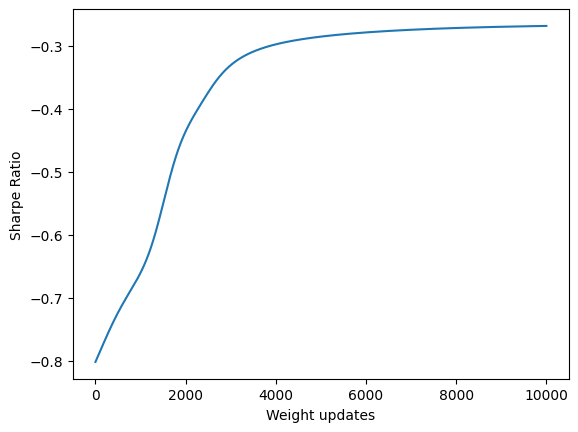

In [23]:
import matplotlib.pyplot as plt
x_df = pd.DataFrame(range(0,num_iter))
plt.plot(x_df,sharpes.numpy(force=True),)
plt.xlabel('Weight updates')
plt.ylabel('Sharpe Ratio')



## Backtesting

In [24]:
from backtesting import BackTester
comp_weights = pd.DataFrame({'Weights':[1/30]*30},index=asset_names) #equal weighting
test_start=date(2022,10,7)
test_end=date(2024,10,7)
tester = BackTester(comp_weights=comp_weights,test_weights=pd.DataFrame(weights['Weights']),start=test_start,end=test_end,tickers=tickers)


[*********************100%***********************]  30 of 30 completed


TESTER


#### Plot backtest results

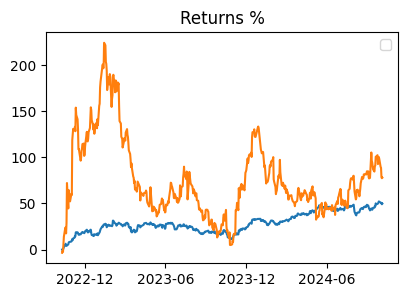

In [44]:
import matplotlib.dates as mdates
comp_returns = tester.cumulative_returns(tester.comparison_portfolio_returns)
test_returns = tester.cumulative_returns(tester.test_portfolio_returns)
ax1=plt.subplot(1,2,1)
ax1.legend(['Comparison','Test'])
ax1.set_title('Returns %')
ax1.figure.set_size_inches(10,3)
ax1.xaxis.set_major_formatter(mdates.AutoDateFormatter('%Y'))
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax1.plot(comp_returns.mul(100))
ax1.plot(test_returns.mul(100))

